In [16]:
!pip install -qU uproot ace_tools awkward_pandas

## Data Acquisition

In [2]:
import uproot, pandas as pd, pprint, re, pathlib

root_path = pathlib.Path("~/Desktop/CERN/LHC-aging-analysis/data/laserROOT/o2_ft0digits.root").expanduser()
file = uproot.open(root_path)

# 1️⃣ peek into the o2sim directory
o2sim_dir = file["o2sim"]
print("Keys under o2sim:")
pprint.pp(o2sim_dir.keys())            # should list TTrees like 'FT0Digit', 'CTPHeader', …

# 2️⃣ find a tree that contains the FT0 digits
tree_name = next(k for k in o2sim_dir.keys() if re.search(r"FT0.*Digit", k, re.I))
tree = o2sim_dir[tree_name]
print("Using tree:", tree_name)

# 3️⃣ load branches -> DataFrame
#df = tree.arrays(library="pd")         # or specify columns=["chanId","adc","tfTime"]
#print(df.head())

Keys under o2sim:
['FT0DIGITSBC',
 'FT0DIGITSBC/FT0DIGITSBC.ref.mFirstEntry',
 'FT0DIGITSBC/FT0DIGITSBC.ref.mEntries',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.triggersignals',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.nChanA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.nChanC',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.amplA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.amplC',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.timeA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.timeC',
 'FT0DIGITSBC/FT0DIGITSBC.mEventStatus',
 'FT0DIGITSBC/FT0DIGITSBC.mIntRecord.bc',
 'FT0DIGITSBC/FT0DIGITSBC.mIntRecord.orbit',
 'FT0DIGITSBC/FT0DIGITSBC.mEventID',
 'FT0DIGITSCH',
 'FT0DIGITSCH/FT0DIGITSCH.ChId',
 'FT0DIGITSCH/FT0DIGITSCH.ChainQTC',
 'FT0DIGITSCH/FT0DIGITSCH.CFDTime',
 'FT0DIGITSCH/FT0DIGITSCH.QTCAmpl']
Using tree: FT0DIGITSBC


In [44]:
import json, pathlib, re, math
import numpy as np
import pandas as pd
import uproot, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import awkward as ak

# Paths
DIGIT_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
RUN_JSON  = pathlib.Path("../data/laserROOT/laser_runs.json")

assert DIGIT_DIR.is_dir(), "Digits directory not found"
assert RUN_JSON.is_file(), "runs.json not found"

# Helper: Gaussian model
def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [45]:
with RUN_JSON.open() as f:
    run_meta = {item["run"]: item["start_ms"] for item in json.load(f)}

print(f"runs.json contains {len(run_meta)} entries")

runs.json contains 228 entries


In [52]:
results     = []
file_re     = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))
failures = 0

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="processing runs"):
    run = int(file_re.match(root_path.name).group(1))

    # 1) read QTC amplitudes (flatten jagged array)
    with uproot.open(root_path) as f:
        qtc_awk = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")
    qtc = ak.to_numpy(ak.flatten(qtc_awk))
    if qtc.size == 0:
        continue

    # 2) histogram + peak
    hist, edges  = np.histogram(qtc, bins="auto")
    bins         = 0.5 * (edges[:-1] + edges[1:])
    x_peak       = bins[np.argmax(hist)]        # ADC value at mode

    # 3) adaptive fit window
    for scale in (0.25, 0.35, 0.45, 0.60):
        mask = (bins >= (1 - scale) * x_peak) & (bins <= (1 + scale) * x_peak)
        if (hist[mask] > 0).sum() >= 5:
            x_fit, y_fit = bins[mask], hist[mask]
            break
    else:
        results.append(dict(run=run, start_ms=run_meta.get(run),
                            adc_mip=np.nan, err=np.nan))
        continue

    # 4) Gaussian fit  →  μ̂, σ̂  (may fail)
    try:
        p0 = (y_fit.max(), x_peak, np.std(qtc))
        popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0, maxfev=8000)
        _, mu, sigma = popt
    except RuntimeError:
        mu, sigma = np.nan, np.nan
        failures = failures + 1

    # 5) **normalise by peak position**
    mu_norm = mu / x_peak if np.isfinite(mu) and x_peak else np.nan
    sigma_norm = sigma / x_peak if np.isfinite(sigma) and x_peak else np.nan

    results.append(dict(run=run,
                        start_ms=run_meta.get(run),
                        adc_mip=mu_norm,
                        err=sigma_norm))

# build DataFrame, discard failed fits
df = (pd.DataFrame(results)
        .dropna(subset=["adc_mip"])
        .sort_values("start_ms"))

print("Result table shape:", df.shape)
print("Failures:", failures)
df.head()

Found 198 ROOT files


processing runs:   0%|          | 0/198 [00:00<?, ?it/s]

Result table shape: (189, 4)
Failures: 0


,run,start_ms,adc_mip,err
0,549661,1712509984000,1.030860,0.113678
1,549749,1712639399000,0.997766,0.116775
2,549824,1712774571000,0.999055,-0.118018
3,549853,1712788504000,0.994662,0.116039
4,549958,1712919188000,0.978508,0.114535


In [53]:
print(df[["adc_mip", "err"]].describe())
print("\nEarliest run :", pd.to_datetime(df['start_ms'], unit='ms').min())
print("Latest run   :", pd.to_datetime(df['start_ms'], unit='ms').max())

          adc_mip         err
count  189.000000  189.000000
mean     1.009128    0.056322
std      0.041902    0.124420
min      0.937589   -0.159639
25%      0.974770   -0.130070
50%      1.001279    0.126968
75%      1.039188    0.137269
max      1.114365    0.160137

Earliest run : 2024-04-07 17:13:04
Latest run   : 2025-07-14 02:54:44.829000


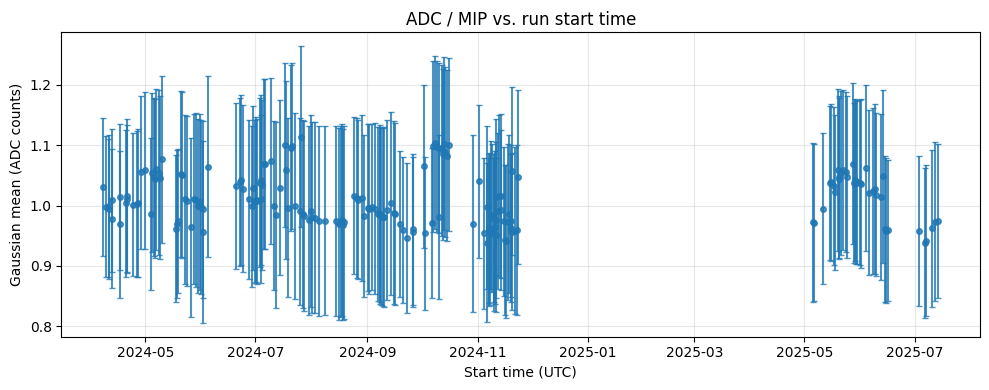

In [62]:
plt.figure(figsize=(10, 4))

# 1) keep only rows with a finite, positive σ
plot_df = df[np.isfinite(df["err"])].copy()
plot_df["err"] = plot_df["err"].abs()         # force positivity

# 2) convert ms → pandas datetime, then to matplotlib
plot_df["time"] = pd.to_datetime(plot_df["start_ms"], unit="ms")

plt.errorbar(
    plot_df["time"],
    plot_df["adc_mip"],
    yerr=plot_df["err"],
    fmt="o",
    ms=4,
    capsize=2,
    alpha=0.8,
)

plt.title("ADC / MIP vs. run start time")
plt.ylabel("Gaussian mean (ADC counts)")
plt.xlabel("Start time (UTC)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Pre-processing & EDA

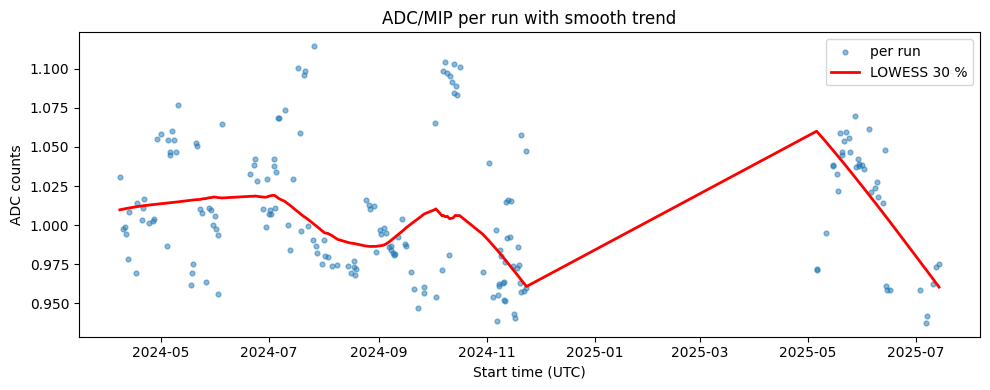

In [55]:
from statsmodels.nonparametric.smoothers_lowess import lowess

x = pd.to_datetime(df['start_ms'], unit='ms')
y = df['adc_mip'].values
# LOWESS with 30 % span
low = lowess(y, x.astype(int), frac=0.3, return_sorted=False)

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=12, alpha=0.5, label='per run')
plt.plot(x, low, color='red', lw=2, label='LOWESS 30 %')
plt.title("ADC/MIP per run with smooth trend")
plt.ylabel("ADC counts")
plt.xlabel("Start time (UTC)")
plt.legend(); plt.tight_layout()

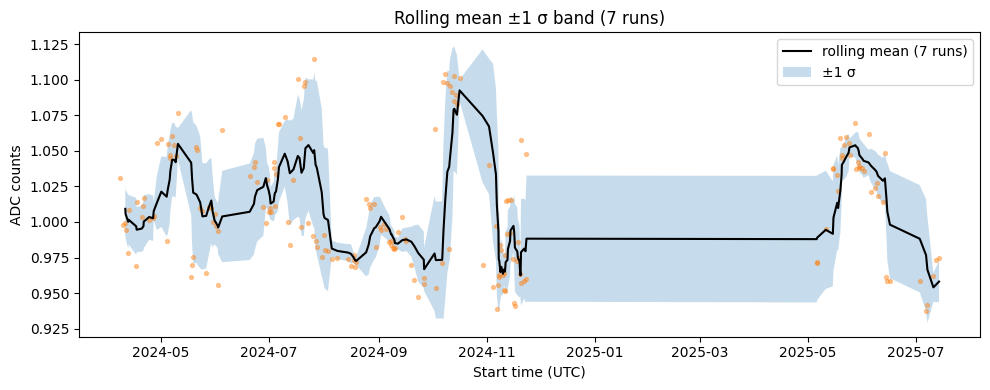

In [56]:
# 7-run rolling statistics
roll_mean  = df['adc_mip'].rolling(7, min_periods=3).mean()
roll_sigma = df['adc_mip'].rolling(7, min_periods=3).std()

plt.figure(figsize=(10,4))
plt.plot(x, roll_mean, color='k', lw=1.5, label='rolling mean (7 runs)')
plt.fill_between(x,
                 roll_mean-roll_sigma,
                 roll_mean+roll_sigma,
                 alpha=0.25, label='±1 σ')
plt.scatter(x, y, s=8, alpha=0.4)
plt.title("Rolling mean ±1 σ band (7 runs)")
plt.ylabel("ADC counts"); plt.xlabel("Start time (UTC)")
plt.legend(); plt.tight_layout()

In [57]:
base = df["adc_mip"].iloc[0]
df["rel_mip"]  = df["adc_mip"] / base
df["rel_err"]  = df["err"]     / base

print("processed runs:", len(df))
df.head()

processed runs: 189


,run,start_ms,adc_mip,err,rel_mip,rel_err
0,549661,1712509984000,1.030860,0.113678,1.000000,0.110275
1,549749,1712639399000,0.997766,0.116775,0.967897,0.113279
2,549824,1712774571000,0.999055,-0.118018,0.969147,-0.114485
3,549853,1712788504000,0.994662,0.116039,0.964885,0.112565
4,549958,1712919188000,0.978508,0.114535,0.949215,0.111106


In [64]:
cut_date = pd.Timestamp("2024-05-01")
mask_time = pd.to_datetime(df["start_ms"], unit="ms") >= cut_date
df = df.loc[mask_time].reset_index(drop=True)

print(f"After cut-off {cut_date.date()}: {len(df)} runs remain "
      f"({df['run'].min()} → {df['run'].max()})")

After cut-off 2024-05-01: 174 runs remain (550897 → 564587)


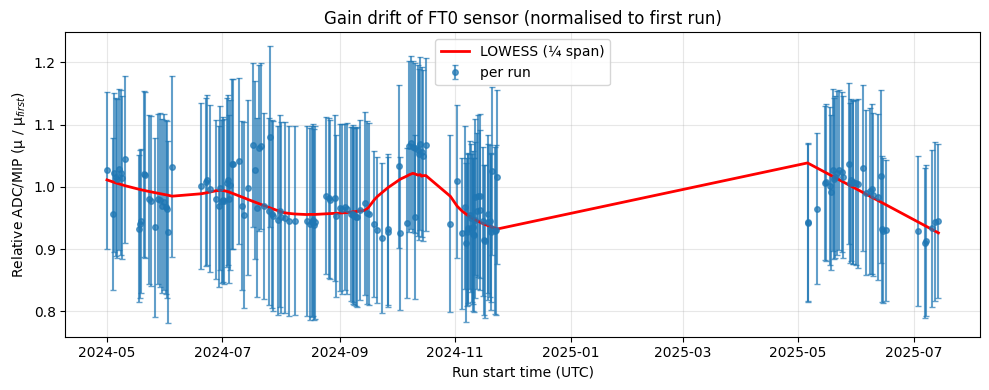

In [65]:
times     = pd.to_datetime(df["start_ms"], unit="ms")

mask      = np.isfinite(df["rel_err"])
plot_x    = times[mask]
plot_y    = df.loc[mask, "rel_mip"]
plot_err  = df.loc[mask, "rel_err"].abs()

plt.figure(figsize=(10, 4))
plt.errorbar(plot_x, plot_y, yerr=plot_err,
             fmt="o", ms=4, capsize=2, alpha=0.7, label="per run")

low = lowess(plot_y, df.loc[mask, "start_ms"], frac=0.25, return_sorted=False)
plt.plot(plot_x, low, color="red", lw=2, label="LOWESS (¼ span)")

plt.ylabel("Relative ADC/MIP (μ / μ$_{first}$)")
plt.xlabel("Run start time (UTC)")
plt.title("Gain drift of FT0 sensor (normalised to first run)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()

In [66]:
# ---------------------------------------------------------------------------
# NEW experiment:  peak / peak@t0   (no Gaussian fit)
# ---------------------------------------------------------------------------
peak_rows, failures = [], 0
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))
file_re     = re.compile(r"run_(\d+)_ft0digits\.root")

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="peak-only runs"):
    run = int(file_re.match(root_path.name).group(1))

    # read & flatten amplitudes
    qtc = ak.to_numpy(
        ak.flatten(
            uproot.open(root_path)
                  ["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"]
                  .array(library="ak")
        )
    )
    if qtc.size == 0:
        failures += 1
        continue

    # histogram + peak position
    hist, edges = np.histogram(qtc, bins="auto")
    bins        = 0.5 * (edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    peak_rows.append({
        "run": run,
        "start_ms": run_meta.get(run),
        "peak_adc": x_peak,
    })

# build tidy table
df_peak = (pd.DataFrame(peak_rows)
             .dropna(subset=["peak_adc"])
             .sort_values("start_ms")
             .reset_index(drop=True))

print(f"Successfully processed {len(df_peak)} runs  |  failures: {failures}")

# normalise to first run’s peak
peak_0 = df_peak.loc[0, "peak_adc"]
df_peak["rel_peak"] = df_peak["peak_adc"] / peak_0

df_peak.head()

Found 198 ROOT files


peak-only runs:   0%|          | 0/198 [00:00<?, ?it/s]

Successfully processed 191 runs  |  failures: 7


,run,start_ms,peak_adc,rel_peak
0,549661,1712509984000,134.5,1.000000
1,549749,1712639399000,152.5,1.133829
2,549824,1712774571000,158.5,1.178439
3,549853,1712788504000,158.5,1.178439
4,549958,1712919188000,152.5,1.133829


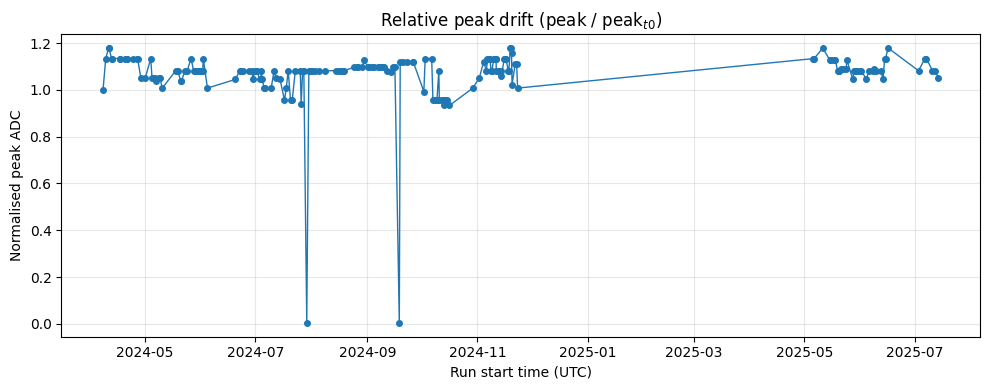

In [67]:
# simple scatter of relative peak drift
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(df_peak["start_ms"], unit="ms"),
         df_peak["rel_peak"], marker="o", ms=4, lw=1)
plt.title("Relative peak drift (peak / peak$_{t0}$)")
plt.ylabel("Normalised peak ADC")
plt.xlabel("Run start time (UTC)")
plt.grid(alpha=0.3)
plt.tight_layout()

In [68]:
# ---------------------------------------------------------------------------
#  loop: ADC/MIP (μ) normalised ONLY by the first run’s peak
# ---------------------------------------------------------------------------
results, failures = [], 0
first_peak = None                       # x_max at t = 0
file_re    = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="processing runs"):
    run = int(file_re.match(root_path.name).group(1))

    # 1) amplitudes → flat NumPy
    qtc = ak.to_numpy(
        ak.flatten(
            uproot.open(root_path)
                  ["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"]
                  .array(library="ak")
        )
    )
    if qtc.size == 0:
        failures += 1
        continue

    # 2) histogram → peak
    hist, edges = np.histogram(qtc, bins="auto")
    bins        = 0.5 * (edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    if first_peak is None:
        first_peak = x_peak               # set reference once

    # 3) adaptive window (≥5 populated bins)
    for scale in (0.25, 0.35, 0.45, 0.60):
        mask = (bins >= (1-scale)*x_peak) & (bins <= (1+scale)*x_peak)
        if (hist[mask] > 0).sum() >= 5:
            x_fit, y_fit = bins[mask], hist[mask]
            break
    else:
        failures += 1
        continue

    # 4) Gaussian fit
    try:
        (_, mu, sigma), _ = curve_fit(
            gauss, x_fit, y_fit,
            p0=(y_fit.max(), x_peak, np.std(qtc)),
            maxfev=8000
        )
    except RuntimeError:
        mu, sigma = np.nan, np.nan
        failures += 1

    # 5) final normalisation: divide by first_peak ONLY
    mu_norm    = mu / first_peak if np.isfinite(mu) else np.nan
    sigma_norm = abs(sigma) / first_peak if np.isfinite(sigma) else np.nan
    peak_rel   = x_peak / first_peak

    results.append(dict(run=run,
                        start_ms=run_meta.get(run),
                        rel_adc_mip=mu_norm,
                        rel_err=sigma_norm,
                        peak_rel=peak_rel))

# tidy DataFrame
df_peaknorm = (pd.DataFrame(results)
                 .dropna(subset=["rel_adc_mip"])
                 .sort_values("start_ms")
                 .reset_index(drop=True))

print("Processed runs:", len(df_peaknorm), "| failures:", failures)
df_peaknorm.head()

Found 198 ROOT files


processing runs:   0%|          | 0/198 [00:00<?, ?it/s]

Processed runs: 189 | failures: 9


,run,start_ms,rel_adc_mip,rel_err,peak_rel
0,549661,1712509984000,1.030860,0.113678,1.000000
1,549749,1712639399000,1.131296,0.132403,1.133829
2,549824,1712774571000,1.177326,0.139077,1.178439
3,549853,1712788504000,1.172148,0.136745,1.178439
4,549958,1712919188000,1.109461,0.129863,1.133829


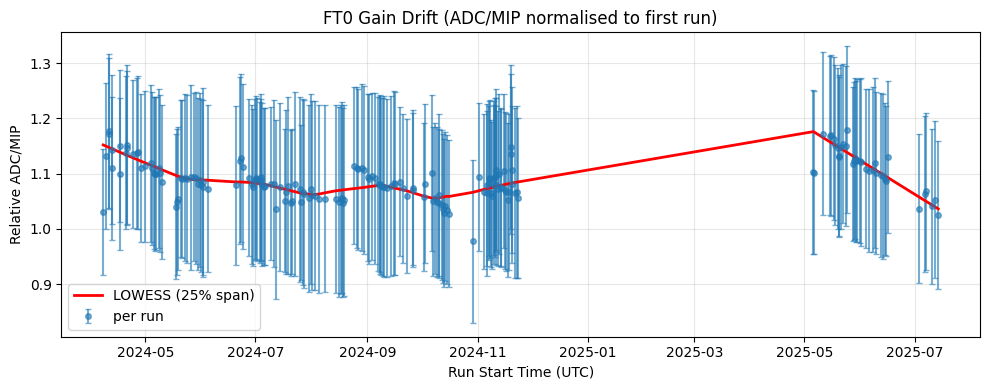

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# If df_peaknorm doesn't exist (e.g. fresh kernel), try loading from CSV produced earlier
try:
    df_plot = df_peaknorm.copy()
except NameError:
    df_plot = pd.read_csv("ft0_laser_gain_timeseries.csv")  # fallback
    # this file would have rel_mip/rel_err; rename for consistency
    if "rel_adc_mip" not in df_plot.columns and "rel_mip" in df_plot.columns:
        df_plot = df_plot.rename(columns={"rel_mip": "rel_adc_mip", "rel_err": "rel_err"})

# Convert start_ms to datetime
df_plot["time"] = pd.to_datetime(df_plot["start_ms"], unit="ms")

# LOWESS smooth of the relative gain
low = lowess(df_plot["rel_adc_mip"], df_plot["start_ms"], frac=0.25, return_sorted=False)

# Plot
plt.figure(figsize=(10, 4))
plt.errorbar(df_plot["time"], df_plot["rel_adc_mip"], yerr=df_plot["rel_err"],
             fmt="o", ms=4, capsize=2, alpha=0.6, label="per run")
plt.plot(df_plot["time"], low, color="red", lw=2, label="LOWESS (25% span)")

plt.title("FT0 Gain Drift (ADC/MIP normalised to first run)")
plt.ylabel("Relative ADC/MIP")
plt.xlabel("Run Start Time (UTC)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
# ---------------------------------------------------------------------------
#  new experiment: weighted-mean of slice (no Gaussian fit)
#  * rel_adc_w  = ⟨ADC⟩_weighted   /  first-run peak
#  * rel_err_w  = weighted σ       /  first-run peak
# ---------------------------------------------------------------------------
w_rows, failures = [], 0
first_peak = None                                  # reference x_max @ t0
file_re    = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="weighted-mean runs"):
    run = int(file_re.match(root_path.name).group(1))

    # flat QTC amplitude vector
    qtc = ak.to_numpy(
        ak.flatten(
            uproot.open(root_path)
                  ["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"]
                  .array(library="ak")
        )
    )
    if qtc.size == 0:
        failures += 1
        continue

    # histogram & peak
    hist, edges = np.histogram(qtc, bins="auto")
    bins        = 0.5 * (edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    # set reference once
    if first_peak is None:
        first_peak = x_peak

    # adaptive slice window (≥5 populated bins)
    for scale in (0.25, 0.35, 0.45, 0.60):
        m = (bins >= (1-scale)*x_peak) & (bins <= (1+scale)*x_peak)
        if (hist[m] > 0).sum() >= 5:
            xs, ws = bins[m], hist[m]
            break
    else:
        failures += 1
        continue

    # ---------- weighted mean & σ ------------------------------------------
    w_sum   = ws.sum()
    w_mean  = np.dot(xs, ws) / w_sum
    w_var   = np.dot(ws, (xs - w_mean) ** 2) / w_sum
    w_sigma = math.sqrt(w_var)

    # ---------- normalise by first-run peak only ---------------------------
    rel_adc_w = w_mean  / first_peak
    rel_err_w = w_sigma / first_peak
    peak_rel  = x_peak  / first_peak

    w_rows.append(dict(run=run,
                       start_ms=run_meta.get(run),
                       rel_adc_w=rel_adc_w,
                       rel_err_w=rel_err_w,
                       peak_rel=peak_rel))

# tidy DataFrame
df_weighted = (pd.DataFrame(w_rows)
                 .dropna(subset=["rel_adc_w"])
                 .sort_values("start_ms")
                 .reset_index(drop=True))

print("Processed:", len(df_weighted), "runs | failures:", failures)
df_weighted.head()

Found 198 ROOT files


weighted-mean runs:   0%|          | 0/198 [00:00<?, ?it/s]

Processed: 189 runs | failures: 9


,run,start_ms,rel_adc_w,rel_err_w,peak_rel
0,549661,1712509984000,1.026852,0.104284,1.000000
1,549749,1712639399000,1.132793,0.121112,1.133829
2,549824,1712774571000,1.179265,0.125868,1.178439
3,549853,1712788504000,1.175475,0.124516,1.178439
4,549958,1712919188000,1.117627,0.120599,1.133829


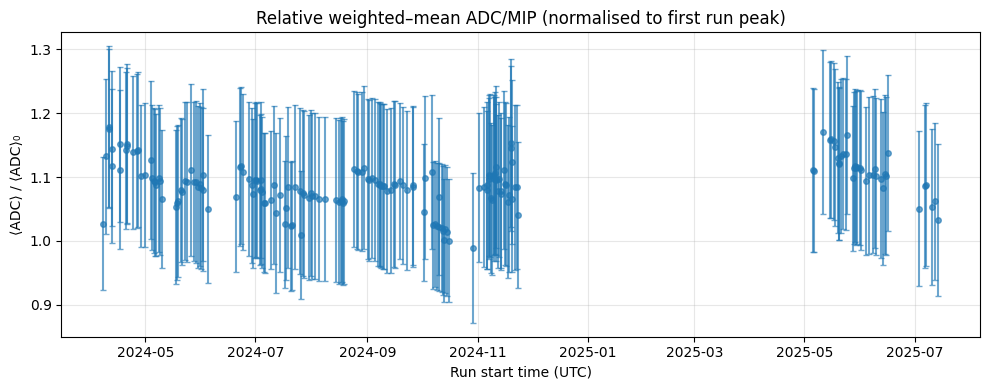

In [72]:
times = pd.to_datetime(df_weighted["start_ms"], unit="ms")

plt.figure(figsize=(10,4))
plt.errorbar(times, df_weighted["rel_adc_w"], yerr=df_weighted["rel_err_w"],
             fmt="o", ms=4, capsize=2, alpha=0.65, label="weighted μ")
plt.title("Relative weighted–mean ADC/MIP (normalised to first run peak)")
plt.ylabel("⟨ADC⟩ / ⟨ADC⟩₀")
plt.xlabel("Run start time (UTC)")
plt.grid(alpha=0.3); plt.tight_layout()

In [1]:
import pathlib, re, gc
import numpy as np, matplotlib.pyplot as plt, uproot
from tqdm.notebook import tqdm

# ---------------- configuration ------------------------------------------
DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins   = np.arange(0, 4096, 8, dtype=np.float32)   # 512 bins of width 8 ADC
n_bins = len(bins) - 1
step   = "50 MB"                                   # chunk size for uproot

# ---------------- pre-allocate -------------------------------------------
digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)
H    = np.zeros((len(digit_files), n_bins), dtype=np.uint32)

print(f"Building histograms for {len(digit_files)} ROOT files …")

for i, path in enumerate(tqdm(digit_files, desc="histograms")):
    runs[i] = int(file_re.match(path.name).group(1))

    with uproot.open(path) as f:
        tree = f["o2sim/FT0DIGITSCH"]
        # iterate over *one numeric branch*; each chunk is a NumPy object array
        for chunk in tree.iterate(["FT0DIGITSCH.QTCAmpl"],
                                  library="np", step_size=step):
            qtc_obj = chunk["FT0DIGITSCH.QTCAmpl"]    # dtype=object, ragged
            if qtc_obj.size:
                flat = np.concatenate(qtc_obj)        # 1-D numeric view
                if flat.size:
                    H[i] += np.histogram(flat, bins=bins)[0].astype(np.uint32)
    gc.collect()                                      # keep RSS low

print("Finished matrix H:", H.shape, "| dtype:", H.dtype)

Building histograms for 198 ROOT files …


histograms:   0%|          | 0/198 [00:00<?, ?it/s]

Finished matrix H: (198, 511) | dtype: uint32


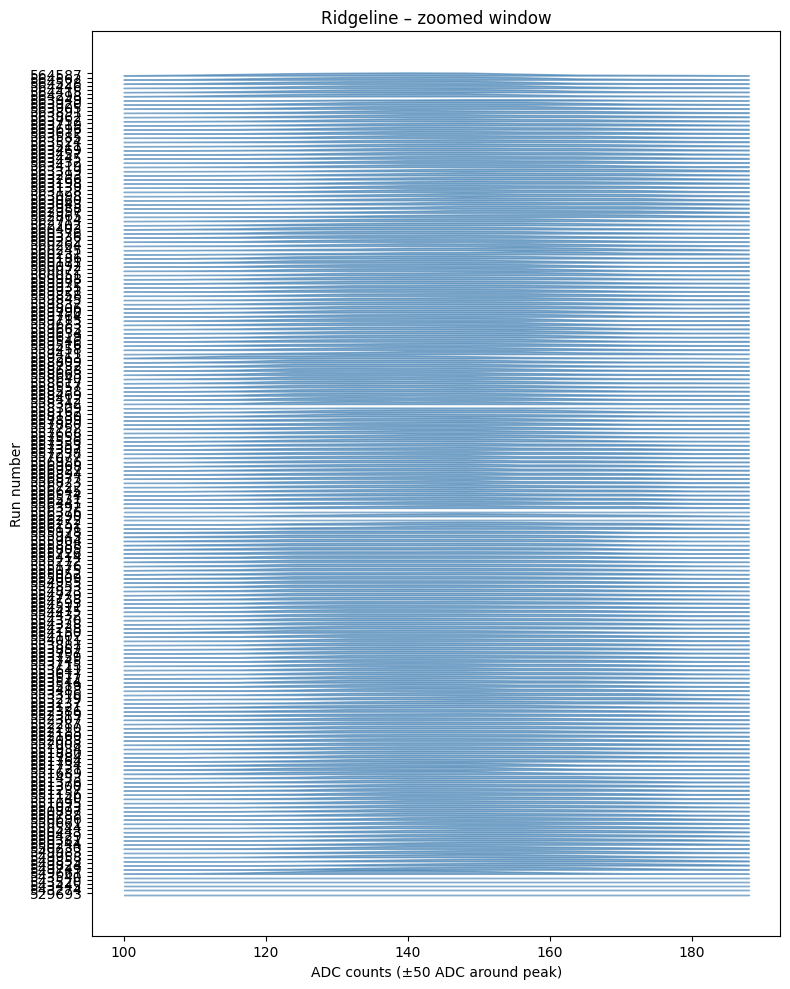

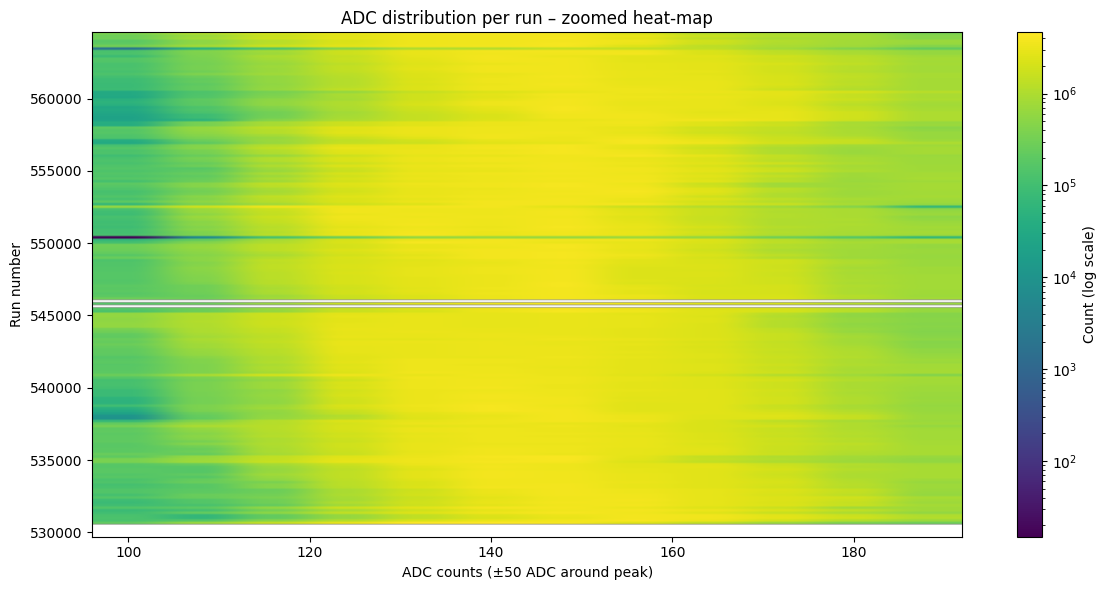

In [3]:
# -------------------------------------------------------------------------
# 1. determine global peak bin
# -------------------------------------------------------------------------
sum_hist   = H.sum(axis=0)                     # collapse all runs
peak_idx   = np.argmax(sum_hist)               # index of modal bin
window_adc = 50                                # ±50 ADC around the peak

# convert "ADC width" into bin indices (bins are 8 ADC wide)
bins_per_side = int(window_adc / (bins[1] - bins[0]))   # here: 50 / 8 = 6
lo, hi = max(0, peak_idx - bins_per_side), min(len(bins) - 1, peak_idx + bins_per_side)

slice_bins   = bins[lo:hi+1]                   # bin edges for plotting
slice_centres = 0.5 * (slice_bins[:-1] + slice_bins[1:])
H_slice      = H[:, lo:hi]                     # same window for counts

# -------------------------------------------------------------------------
# 2. ridgeline within the ±50 ADC window
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 10))
offset, scale = 0.0, 0.90 / H_slice.max()      # rescale for new range

for row in H_slice:
    ax.fill_between(slice_centres,
                    offset,
                    offset + row * scale,
                    color="steelblue", alpha=0.65)
    offset += 1

ax.set_yticks(np.arange(len(runs)) + 0.5)
ax.set_yticklabels(runs)
ax.set_xlabel("ADC counts (±50 ADC around peak)")
ax.set_ylabel("Run number")
ax.set_title("Ridgeline – zoomed window")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------------
# 3. heat-map in the same window
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.imshow(H_slice, aspect='auto', origin='lower',
           extent=[slice_bins[0], slice_bins[-1], runs[0], runs[-1]],
           cmap='viridis', norm='log')
plt.colorbar(label='Count (log scale)')
plt.xlabel("ADC counts (±50 ADC around peak)")
plt.ylabel("Run number")
plt.title("ADC distribution per run – zoomed heat-map")
plt.tight_layout(); plt.show()

In [4]:
import pathlib, re, gc
import numpy as np, uproot, awkward as ak
from tqdm.notebook import tqdm

DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins_adc    = np.arange(0, 4096, 8, dtype=np.float32)        # 512 ADC bins
n_bins      = len(bins_adc) - 1
n_channels  = 256                                             # FT0 pad indexes
step_size   = "50 MB"

digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)

# final tensor:  run × channel × bin
Hch = np.zeros((len(digit_files), n_channels, n_bins), dtype=np.uint32)

for i, p in enumerate(tqdm(digit_files, desc="per-channel hists")):
    runs[i] = int(file_re.match(p.name).group(1))

    with uproot.open(p) as f:
        tree = f["o2sim/FT0DIGITSCH"]

        for chunk in tree.iterate(
                ["FT0DIGITSCH.QTCAmpl", "FT0DIGITSCH.ChId"],
                library="ak", step_size=step_size):

            adc_flat  = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.QTCAmpl"]))
            chid_flat = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.ChId"]))

            # histogram each channel locally → add into global tensor
            for ch in np.unique(chid_flat):
                mask = chid_flat == ch
                if mask.any():
                    Hch[i, ch] += np.histogram(adc_flat[mask], bins=bins_adc)[0].astype(np.uint32)

    gc.collect()
print("Tensor Hch shape:", Hch.shape)   # (nRuns, 256, 512)

per-channel hists:   0%|          | 0/198 [00:00<?, ?it/s]

Tensor Hch shape: (198, 256, 511)


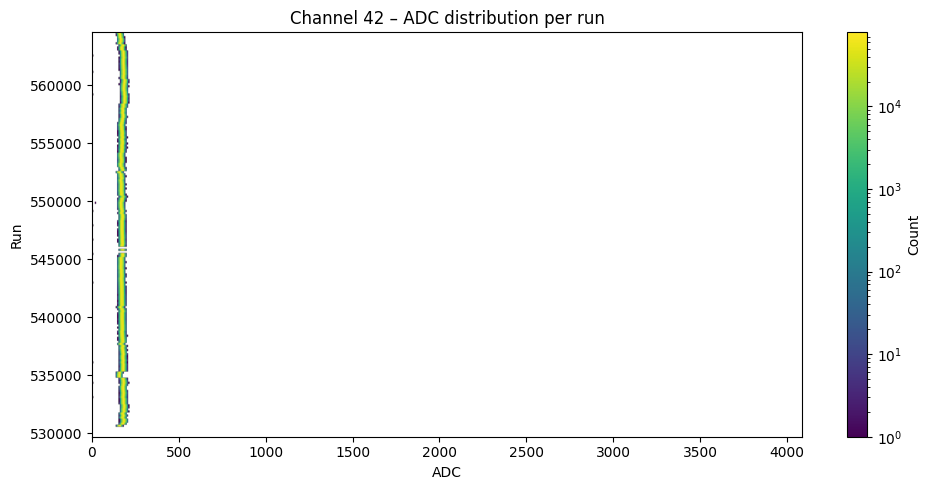

In [5]:
import matplotlib.pyplot as plt

ch = 42                                    # pick a channel
plt.figure(figsize=(10, 5))
plt.imshow(Hch[:, ch], aspect='auto', origin='lower',
           extent=[bins_adc[0], bins_adc[-1], runs[0], runs[-1]],
           cmap='viridis', norm='log')
plt.colorbar(label='Count')
plt.title(f"Channel {ch} – ADC distribution per run")
plt.xlabel("ADC"); plt.ylabel("Run")
plt.tight_layout(); plt.show()

Channels with data: 212 / 256


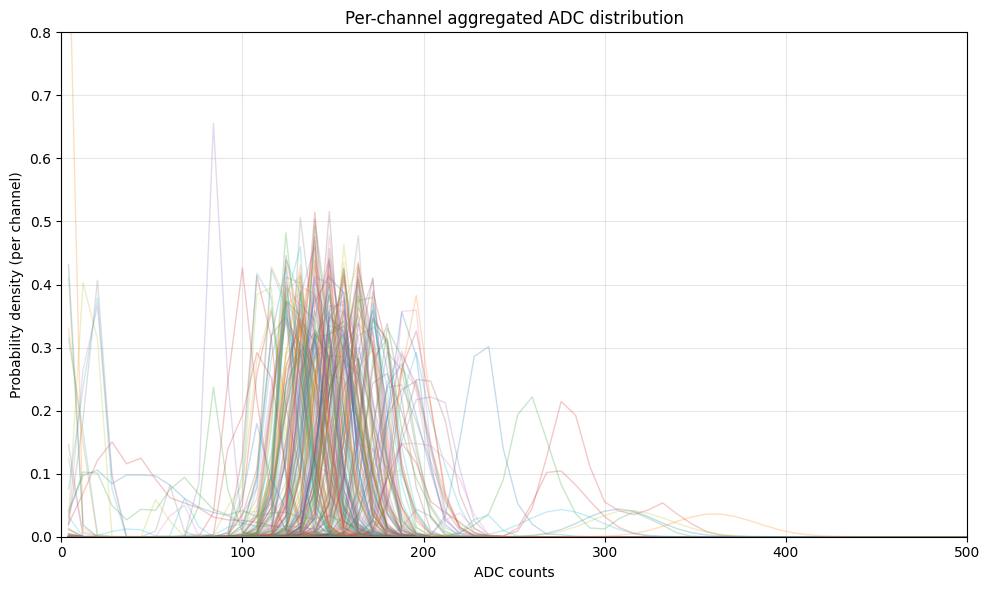

In [8]:
# ----------------------------------------------------------------------
# Quick EDA – how many populated channels? + over-plotted histograms
#  requires tensor Hch [nRuns × 256 × nBins] and `bins_adc` from earlier
# ----------------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt

# 1) how many channels have at least one non-zero bin across all runs
populated = (Hch.sum(axis=(0, 2)) > 0)
n_pop     = populated.sum()
print(f"Channels with data: {n_pop} / {Hch.shape[1]}")

# 2) over-plot one histogram per populated channel (aggregate over runs)
bin_centres = 0.5 * (bins_adc[:-1] + bins_adc[1:])

plt.figure(figsize=(10, 6))
for ch in np.where(populated)[0]:
    counts = Hch[:, ch].sum(axis=0)                  # aggregate over runs
    if counts.sum() == 0:
        continue
    # density=True for better comparability across channels
    plt.plot(bin_centres,
             counts / counts.sum(),
             lw=1,
             alpha=0.25,                             # fade overlap
             label=f"Ch {ch}" if ch < 8 else None)   # avoid huge legend

plt.xlim(0, 500)   # <-- X-axis 0 … 500 ADC
plt.ylim(0, 0.8)   # <-- Y-axis 0 … 0.8

plt.title("Per-channel aggregated ADC distribution")
plt.xlabel("ADC counts")
plt.ylabel("Probability density (per channel)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Ageing trends for one channel (PMA3/CH02 : 24 linear)

In [29]:
import pandas as pd, gc
from tqdm.auto import tqdm

# ---- constants -----------------------------------------------------------
TARGET_CH   = 24                     # PMA3/CH02  (0-based)
REF_CHS     = [208, 210, 211]        # PMC9/CH05,07,08

In [30]:
# Cell 2 – robust Gaussian fit -------------------------------------------
import numpy as np
from scipy.optimize import curve_fit

MIN_ENTRIES = 300          # skip fits if fewer digits than this

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def try_gaussian(data, frac=0.25):
    """
    Safe wrapper around curve_fit.
    Returns (mu, sigma) or (np.nan, np.nan) on any problem.
    """
    if data.size < MIN_ENTRIES:
        return np.nan, np.nan

    hist, edges = np.histogram(data, bins="auto")
    bins        = 0.5*(edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    for scale in (frac, 0.35, 0.45, 0.60):
        mask = (bins >= (1-scale)*x_peak) & (bins <= (1+scale)*x_peak)
        if (hist[mask] > 0).sum() >= 5:
            try:
                p0 = (hist[mask].max(), x_peak, np.std(data))
                popt, _ = curve_fit(gauss, bins[mask], hist[mask],
                                    p0=p0, maxfev=8000)
                return popt[1], popt[2]
            except RuntimeError:
                break
    return np.nan, np.nan

In [39]:
# -------- parameters you can tune ------------------------------------------
MIN_ENTRIES  = 300         # skip channels with fewer digits
MIN_REFS     = 2           # need ≥ this many ref-channel fits to accept a run
MAD_CLIP     = 4.0         # discard a μ if it is > MAD_CLIP×MAD away from median
# ----------------------------------------------------------------------------

import numpy as np, pandas as pd, uproot, awkward as ak, pathlib, json, gc
from tqdm.auto import tqdm
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit


def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def safe_mu(arr, frac=0.25):
    if arr.size < MIN_ENTRIES:
        return np.nan
    h, e = np.histogram(arr, bins="auto")
    b    = 0.5*(e[:-1]+e[1:])
    pk   = b[np.argmax(h)]
    for sc in (frac, .35, .45, .60):
        m = (b >= (1-sc)*pk) & (b <= (1+sc)*pk)
        if (h[m] > 0).sum() >= 5:
            try:
                p0 = (h[m].max(), pk, np.std(arr))
                return curve_fit(gauss, b[m], h[m], p0=p0, maxfev=8000)[0][1]
            except RuntimeError:
                break
    return np.nan


DIG_DIR   = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
RUN_META  = {int(d["run"]): d["start_ms"]
             for d in json.load(open("../data/laserROOT/laser_runs.json"))}

rows, dropped_fewrefs, dropped_spike = [], 0, 0
for p in tqdm(sorted(DIG_DIR.glob("run_*_ft0digits.root")), desc="runs"):
    run = int(p.name.split("_")[1])
    t_ms = RUN_META.get(run)
    if t_ms is None:
        continue                      # no timestamp → skip
    with uproot.open(p) as f:
        qtc = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")

    mu_tgt = safe_mu(ak.to_numpy(qtc[:, TARGET_CH].to_numpy().flatten()))
    if not np.isfinite(mu_tgt):
        continue                      # bad target fit

    mu_refs = [safe_mu(ak.to_numpy(qtc[:, ch].to_numpy().flatten()))
               for ch in REF_CHS]
    mu_refs = [x for x in mu_refs if np.isfinite(x)]
    if len(mu_refs) < MIN_REFS:
        dropped_fewrefs += 1
        continue

    # clip obvious outliers among refs (robust MAD method)
    med, mad = np.median(mu_refs), median_abs_deviation(mu_refs)
    mu_refs = [x for x in mu_refs if abs(x-med) < MAD_CLIP*mad]
    if len(mu_refs) < MIN_REFS:
        dropped_spike += 1
        continue

    rows.append(dict(run=run, t_ms=t_ms,
                     mu_tgt=mu_tgt,
                     mu_ref=np.mean(mu_refs),
                     n_ref=len(mu_refs)))

print(f"→ kept {len(rows)} runs, dropped few-ref={dropped_fewrefs}, "
      f"dropped spike={dropped_spike}")

df = pd.DataFrame(rows).sort_values("t_ms").reset_index(drop=True)

# --- normalise to t0 ---------------------------------------------------------
norm1 = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref"]
df["rel_gain"] = (df["mu_tgt"] / df["mu_ref"]) / norm1
df["time"]     = pd.to_datetime(df["t_ms"], unit="ms")
df.head()

runs:   0%|          | 0/198 [00:00<?, ?it/s]

→ kept 64 runs, dropped few-ref=126, dropped spike=0


,run,t_ms,mu_tgt,mu_ref,n_ref,rel_gain,time
0,549661,1712509984000,165.382555,130.482888,2,1.000000,2024-04-07 17:13:04
1,549824,1712774571000,210.307866,149.496889,2,1.109909,2024-04-10 18:42:51
2,550443,1713674182000,200.371935,155.305453,3,1.017921,2024-04-21 04:36:22
3,550661,1714130003000,197.327490,151.533536,2,1.027407,2024-04-26 11:13:23
4,550696,1714161163000,197.928119,156.987556,3,0.994732,2024-04-26 19:52:43


In [40]:
# Cell 4 – derive relative gain ------------------------------------------
# norm₁  =  μ_target(t0) / μ_ref(t0)
mu_tgt_0  = df.loc[0, "mu_tgt"]
mu_ref_0  = df.loc[0, "mu_ref"]
norm1     = mu_tgt_0 / mu_ref_0

df["rel_gain"] = (df["mu_tgt"] / df["mu_ref"]) / norm1
df["time"]     = pd.to_datetime(df["t_ms"], unit="ms")

print("norm₁ =", norm1)
df.head()

norm₁ = 1.2674654729209687


,run,t_ms,mu_tgt,mu_ref,n_ref,rel_gain,time
0,549661,1712509984000,165.382555,130.482888,2,1.000000,2024-04-07 17:13:04
1,549824,1712774571000,210.307866,149.496889,2,1.109909,2024-04-10 18:42:51
2,550443,1713674182000,200.371935,155.305453,3,1.017921,2024-04-21 04:36:22
3,550661,1714130003000,197.327490,151.533536,2,1.027407,2024-04-26 11:13:23
4,550696,1714161163000,197.928119,156.987556,3,0.994732,2024-04-26 19:52:43


In [37]:
df.head(20)

,run,t_ms,mu_tgt,mu_ref,n_ref,rel_gain,time
0,549661,1712509984000,165.382555,136.091424,3,1.000000,2024-04-07 17:13:04
1,549749,1712639399000,203.931245,991.756543,1,0.169208,2024-04-09 05:09:59
2,549824,1712774571000,210.307866,149.496889,2,1.157616,2024-04-10 18:42:51
3,549853,1712788504000,208.588028,1003.076778,1,0.171118,2024-04-10 22:35:04
4,550230,1713306418000,192.373338,996.989177,1,0.158780,2024-04-16 22:26:58
5,550381,1713583082000,198.695902,984.107427,1,0.166145,2024-04-20 03:18:02
6,550443,1713674182000,200.371935,155.305453,3,1.061674,2024-04-21 04:36:22
7,550661,1714130003000,197.327490,151.533536,2,1.071568,2024-04-26 11:13:23
8,550696,1714161163000,197.928119,156.987556,3,1.037489,2024-04-26 19:52:43
9,550788,1714316257000,191.266674,151.811662,2,1.036753,2024-04-28 14:57:37


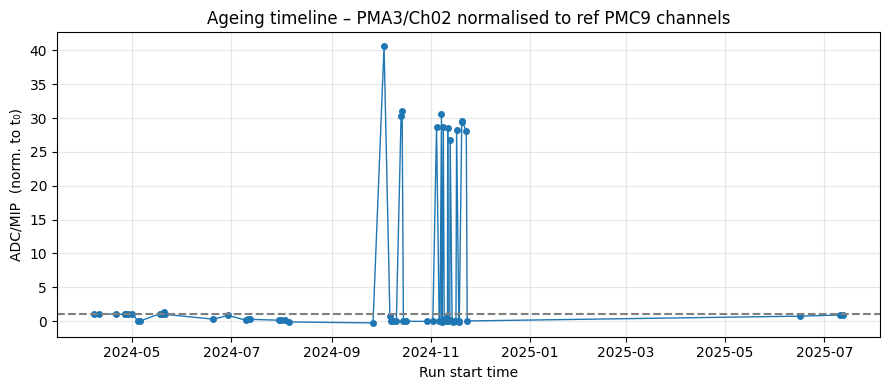

In [41]:
# Cell 5 – visualise ------------------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(df["time"], df["rel_gain"], "o-", ms=4, lw=1)
plt.axhline(1, ls="--", c="grey")
plt.title("Ageing timeline – PMA3/Ch02 normalised to ref PMC9 channels")
plt.ylabel("ADC/MIP  (norm. to t₀)")
plt.xlabel("Run start time")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

In [43]:
df["rel_gain"].tail()

59    28.090406
60     0.029733
61     0.742384
62     0.915157
63     0.907777
Name: rel_gain, dtype: float64

In [44]:
# Cell X – compare target & refs at first vs last timestamp ---------------
import uproot, awkward as ak, numpy as np, pandas as pd
from itertools import islice

# ---- helper (same fitter used before) -----------------------------------
def channel_mu(tree, ch):
    arr = ak.to_numpy(tree["FT0DIGITSCH.QTCAmpl"].array(library="ak")[:, ch]
                      .to_numpy().flatten())
    return safe_mu(arr)

channels = [TARGET_CH] + REF_CHS
labels   = ["target"] + [f"ref{i+1}" for i in range(len(REF_CHS))]

summary  = []

for pos, lbl in zip([0, -1], ["first", "last"]):
    run_id   = df.iloc[pos]["run"]
    rootfile = DIG_DIR / f"run_{run_id}_ft0digits.root"
    with uproot.open(rootfile) as f:
        tree = f["o2sim/FT0DIGITSCH"]
        mus  = [channel_mu(tree, ch) for ch in channels]

    summary.append(
        pd.Series(dict(timestamp=pd.to_datetime(df.iloc[pos]["t_ms"], unit="ms"),
                       run=run_id, **dict(zip(labels, mus))),
                  name=lbl)
    )

compare = pd.concat(summary, axis=1).T
compare

,timestamp,run,target,ref1,ref2,ref3
first,2024-04-07 17:13:04,549661,165.382555,132.071351,147.308496,128.894424
last,2025-07-12 07:37:39.856000,564562,173.747614,158.507426,144.265509,150.254557


area:   0%|          | 0/198 [00:00<?, ?it/s]

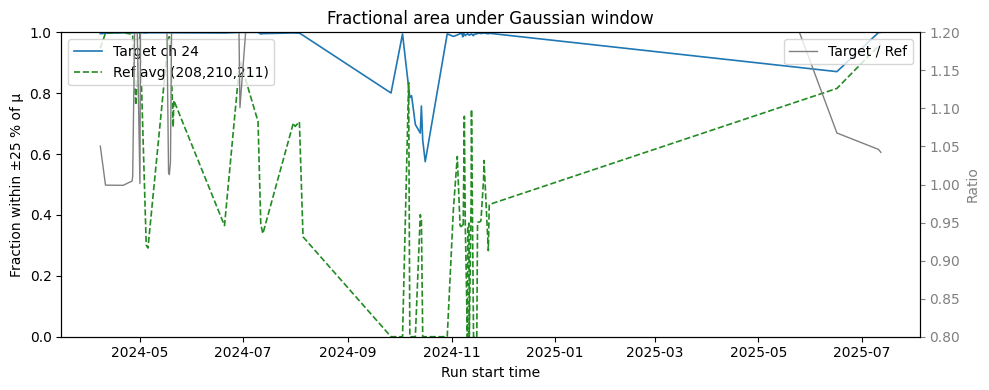

In [45]:
# ▣ Cell – fractional-area timeline  ───────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt, uproot, awkward as ak
from tqdm.auto import tqdm

# ---------------- parameters (consistent with earlier cells) --------------
FRAC_WINDOW = 0.25        # ±25 % around μ (keep in sync with safe_mu)
BINS_ADC    = np.arange(0, 4096, 8)   # fixed binning for stable area estimates

area_rows = []

for p in tqdm(sorted(DIG_DIR.glob("run_*_ft0digits.root")), desc="area"):
    run = int(p.name.split("_")[1])
    t_ms = RUN_META.get(run)
    if t_ms is None:
        continue

    with uproot.open(p) as f:
        qtc = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")

    # -- helper that returns fractional area inside window ------------------
    def frac_area(ch, mu):
        arr = ak.to_numpy(qtc[:, ch].to_numpy().flatten())
        if arr.size == 0 or not np.isfinite(mu):
            return np.nan
        h, _ = np.histogram(arr, bins=BINS_ADC)
        centres = 0.5 * (BINS_ADC[:-1] + BINS_ADC[1:])
        mask = (centres >= (1-FRAC_WINDOW)*mu) & (centres <= (1+FRAC_WINDOW)*mu)
        area = h[mask].sum()
        return area / h.sum() if h.sum() else np.nan

    # target μ was already fitted – fetch from df to avoid refitting
    rec = df.loc[df.run == run]
    if rec.empty:
        continue
    mu_tgt = rec.mu_tgt.values[0]

    area_tgt = frac_area(TARGET_CH, mu_tgt)
    ref_areas = []
    for ch in REF_CHS:
        mu_ref = safe_mu(
            ak.to_numpy(qtc[:, ch].to_numpy().flatten()))   # quick fit
        ref_areas.append(frac_area(ch, mu_ref))
    ref_areas = [x for x in ref_areas if np.isfinite(x)]
    if not ref_areas:
        continue

    area_rows.append(dict(run=run, t_ms=t_ms,
                          frac_tgt=area_tgt,
                          frac_ref=np.mean(ref_areas)))

# convert to tidy DataFrame -------------------------------------------------
area_df = (pd.DataFrame(area_rows)
             .dropna()
             .sort_values("t_ms")
             .assign(time=lambda d: pd.to_datetime(d.t_ms, unit="ms"))
             .reset_index(drop=True))

# ----------------------  simple visualisation  ----------------------------
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(area_df.time, area_df.frac_tgt,  label="Target ch 24",  lw=1.2)
ax.plot(area_df.time, area_df.frac_ref,  label="Ref avg (208,210,211)",
        lw=1.2, ls="--", color="forestgreen")

ax2 = ax.twinx()
ax2.plot(area_df.time,
         area_df.frac_tgt / area_df.frac_ref,
         color="grey", lw=1, label="Target / Ref")
ax2.set_ylabel("Ratio", color="grey")
ax2.tick_params(axis="y", colors="grey")

ax.set_ylabel(f"Fraction within ±{int(FRAC_WINDOW*100)} % of μ")
ax.set_xlabel("Run start time")
ax.set_ylim(0, 2)            # fractions ∈ [0,1]
ax2.set_ylim(0.8, 1.2)       # tweak if needed
ax.set_title("Fractional area under Gaussian window")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

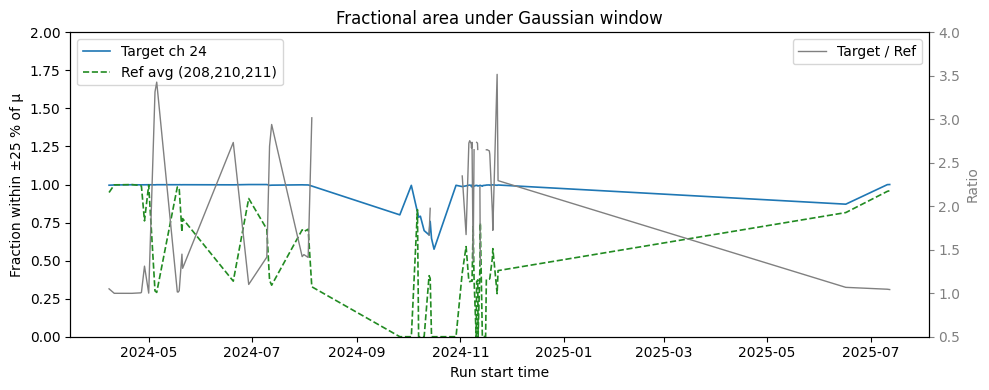

In [51]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(area_df.time, area_df.frac_tgt,  label="Target ch 24",  lw=1.2)
ax.plot(area_df.time, area_df.frac_ref,  label="Ref avg (208,210,211)",
        lw=1.2, ls="--", color="forestgreen")

ax2 = ax.twinx()
ax2.plot(area_df.time,
         area_df.frac_tgt / area_df.frac_ref,
         color="grey", lw=1, label="Target / Ref")
ax2.set_ylabel("Ratio", color="grey")
ax2.tick_params(axis="y", colors="grey")

ax.set_ylabel(f"Fraction within ±{int(FRAC_WINDOW*100)} % of μ")
ax.set_xlabel("Run start time")
ax.set_ylim(0, 2)            # fractions ∈ [0,1]
ax2.set_ylim(0.5, 4)       # tweak if needed
ax.set_title("Fractional area under Gaussian window")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [52]:
with uproot.open(root_path) as f:
    tree = f["o2sim/FT0DIGITSCH"]
    chid  = tree["FT0DIGITSCH.ChId"].array(library="ak")       # jagged uint16
    ampl  = tree["FT0DIGITSCH.QTCAmpl"].array(library="ak")    # jagged uint16

In [55]:
def channel_adc(chid_jagged, ampl_jagged, target):
    """
    Return a flat NumPy array of amplitudes for one linear channel.
    Works even when events contain variable numbers of digits.
    """
    mask   = (chid_jagged == target)           # jagged boolean
    sel    = ampl_jagged[mask]                 # still jagged
    flat   = ak.flatten(sel)                   # 1-D Awkward array
    return ak.to_numpy(flat)                   # → NumPy

In [56]:
# target
tgt_adc = channel_adc(chid, ampl, TARGET_CH)
mu_tgt, _ = fit_gaussian(tgt_adc)

# references
ref_mus = []
for ch in REF_CHS:
    ref_adc = channel_adc(chid, ampl, ch)
    mu_ref, _ = fit_gaussian(ref_adc)
    if np.isfinite(mu_ref):
        ref_mus.append(mu_ref)

Fit failed
Fit failed
Fit failed


In [74]:
import pathlib, re, gc
import numpy as np, uproot, awkward as ak
from tqdm.notebook import tqdm

DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins_adc    = np.arange(0, 4096, 8, dtype=np.float32)        # 512 ADC bins
n_bins      = len(bins_adc) - 1
n_channels  = 256                                             # FT0 pad indexes
step_size   = "50 MB"

digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)

# final tensor:  run × channel × bin
Hch = np.zeros((len(digit_files), n_channels, n_bins), dtype=np.uint32)

for i, p in enumerate(tqdm(digit_files, desc="per-channel hists")):
    runs[i] = int(file_re.match(p.name).group(1))

    with uproot.open(p) as f:
        tree = f["o2sim/FT0DIGITSCH"]

        for chunk in tree.iterate(
                ["FT0DIGITSCH.QTCAmpl", "FT0DIGITSCH.ChId"],
                library="ak", step_size=step_size):

            adc_flat  = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.QTCAmpl"]))
            chid_flat = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.ChId"]))

            # histogram each channel locally → add into global tensor
            for ch in np.unique(chid_flat):
                mask = chid_flat == ch
                if mask.any():
                    Hch[i, ch] += np.histogram(adc_flat[mask], bins=bins_adc)[0].astype(np.uint32)

    gc.collect()
print("Tensor Hch shape:", Hch.shape)   # (nRuns, 256, 512)

per-channel hists:   0%|          | 0/198 [00:00<?, ?it/s]

Tensor Hch shape: (198, 256, 511)


In [99]:
# Cell ▸ ageing timeline  (target ch 24 vs refs 208/210/211)
import numpy as np, pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -------------------------------------------------------------------
BIN_CENTRES = 0.5 * (BINS_ADC[:-1] + BINS_ADC[1:])        # 512 centres
TGT_CH      = 24                                          # PMA3/Ch02
REF_CHS     = [208, 210, 211]                             # PMC9/Ch05,07,08
FRAC        = 0.25                                        # ±25 % fit window
# -------------------------------------------------------------------

def gauss(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def fit_mu(hist, frac=FRAC):
    """Return μ from a Gaussian fit on a fractional slice; np.nan if fail."""
    if hist.sum() < 50:        # too few entries → unreliable
        return np.nan

    x_peak = BIN_CENTRES[np.argmax(hist)]
    for scale in (frac, 0.35, 0.45, 0.60):
        m = (BIN_CENTRES >= (1 - scale) * x_peak) & (BIN_CENTRES <= (1 + scale) * x_peak)
        if hist[m].sum() < 10:         # still too few points
            continue
        try:
            p0   = (hist[m].max(), x_peak, 160.)
            popt, _ = curve_fit(gauss, BIN_CENTRES[m], hist[m], p0=p0,
                                maxfev=4000, bounds=([0, 0, 0], np.inf))
            return popt[1]             # μ
        except RuntimeError:
            pass
    return np.nan

records = []
for i in tqdm(range(len(runs)), desc="fits"):
    h_tgt = Hch[i, TGT_CH]
    mu_tgt = fit_mu(h_tgt)

    mu_refs = [fit_mu(Hch[i, ch]) for ch in REF_CHS]
    mu_ref_avg = np.nanmean(mu_refs)

    if np.isfinite(mu_tgt) and np.isfinite(mu_ref_avg):
        records.append(dict(run=runs[i],
                            index=i,
                            mu_tgt=mu_tgt,
                            mu_ref=mu_ref_avg))

df = pd.DataFrame(records).sort_values("index").reset_index(drop=True)

# --- baseline normalisation (first valid point) ---------------------------
baseline = (df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref"])
df["aging"] = (df["mu_tgt"] / df["mu_ref"]) / baseline

print("First rows:")
display(df.head())

fits:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_9079/3491910286.py:42: RuntimeWarning: Mean of empty slice
  mu_ref_avg = np.nanmean(mu_refs)
/tmp/ipykernel_9079/3491910286.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gauss, BIN_CENTRES[m], hist[m], p0=p0,


First rows:


,run,index,mu_tgt,mu_ref,aging
0,549661,5,163.436523,4.0,1.000000
1,549749,6,173.611473,4.0,1.062256
2,549824,7,182.994799,4.0,1.119669
3,549853,8,183.104426,4.0,1.120340
4,549958,9,171.819017,4.0,1.051289


In [100]:
run_meta = pd.read_json("../data/laserROOT/laser_runs.json")
df = df.merge(run_meta, how="left", on="run")
df["time"] = pd.to_datetime(df["start_ms"], unit="ms")

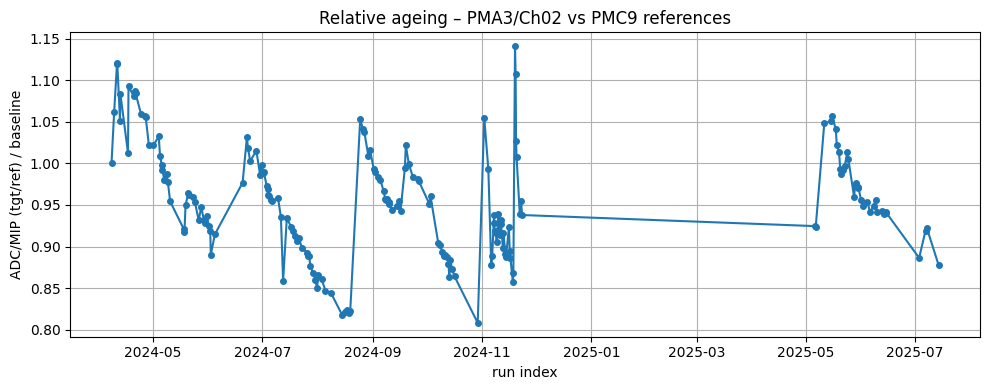

In [101]:
plt.figure(figsize=(10,4))
plt.plot(df["time"], df["aging"], "o-", ms=4)
plt.xlabel("run index")
plt.ylabel("ADC/MIP (tgt/ref) / baseline")
plt.title("Relative ageing – PMA3/Ch02 vs PMC9 references")
plt.grid()
plt.tight_layout()
plt.show()

In [86]:
# ╔════════════════════════════════════════════════════════════════════════╗
# ║  CELL A – build df with ageing ratio  (makes column "norm")           ║
# ╚════════════════════════════════════════════════════════════════════════╝
import pandas as pd, numpy as np
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
import math, gc

# -- helper ---------------------------------------------------------------
def gauss(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def fit_mu(counts, bins):
    """Return Gaussian mean μ (NaN if fit fails)."""
    if counts.sum() < 50:          # skip tiny histograms
        return np.nan
    x  = 0.5 * (bins[:-1] + bins[1:])
    p0 = (counts.max(), x[counts.argmax()], 50.)
    try:
        popt, _ = curve_fit(gauss, x, counts, p0=p0, maxfev=6000)
        return popt[1]             # μ
    except Exception:
        return np.nan

# -- 1. metadata table ----------------------------------------------------
meta_txt = """ch,pm,ring
0,PMA5,A inner
1,PMA5,A inner
2,PMA5,A inner
3,PMA5,A inner
4,PMA6,A inner
5,PMA6,A inner
6,PMA6,A inner
7,PMA6,A inner
8,PMA7,A inner
9,PMA7,A inner
10,PMA7,A inner
11,PMA7,A inner
12,PMA0,A inner
13,PMA0,A inner
14,PMA0,A inner
15,PMA0,A inner
16,PMA1,A inner
17,PMA1,A inner
18,PMA1,A inner
19,PMA1,A inner
20,PMA2,A inner
21,PMA2,A inner
22,PMA2,A inner
23,PMA2,A inner
24,PMA3,A inner
25,PMA3,A inner
26,PMA3,A inner
27,PMA3,A inner
28,PMA4,A inner
29,PMA4,A inner
30,PMA4,A inner
31,PMA4,A inner
32,PMA5,A outer
33,PMA5,A outer
34,PMA5,A outer
35,PMA5,A outer
36,PMA6,A outer
37,PMA6,A outer
38,PMA6,A outer
39,PMA6,A outer
40,PMA6,A outer
41,PMA6,A outer
42,PMA6,A outer
43,PMA6,A outer
44,PMA7,A outer
45,PMA7,A outer
46,PMA7,A outer
47,PMA7,A outer
48,PMA7,A outer
49,PMA7,A outer
50,PMA7,A outer
51,PMA7,A outer
52,PMA0,A outer
53,PMA0,A outer
54,PMA0,A outer
55,PMA0,A outer
56,PMA0,A outer
57,PMA0,A outer
58,PMA0,A outer
59,PMA0,A outer
60,PMA1,A outer
61,PMA1,A outer
62,PMA1,A outer
63,PMA1,A outer
64,PMA1,A outer
65,PMA1,A outer
66,PMA1,A outer
67,PMA1,A outer
68,PMA2,A outer
69,PMA2,A outer
70,PMA2,A outer
71,PMA2,A outer
72,PMA2,A outer
73,PMA2,A outer
74,PMA2,A outer
75,PMA2,A outer
76,PMA3,A outer
77,PMA3,A outer
78,PMA3,A outer
79,PMA3,A outer
80,PMA3,A outer
81,PMA3,A outer
82,PMA3,A outer
83,PMA3,A outer
84,PMA4,A outer
85,PMA4,A outer
86,PMA4,A outer
87,PMA4,A outer
88,PMA4,A outer
89,PMA4,A outer
90,PMA4,A outer
91,PMA4,A outer
92,PMA5,A outer
93,PMA5,A outer
94,PMA5,A outer
95,PMA5,A outer
96,PMC3,C inner
97,PMC3,C inner
98,PMC3,C inner
99,PMC3,C inner
100,PMC8,C inner
101,PMC8,C inner
102,PMC8,C inner
103,PMC8,C inner
104,PMC2,C inner
105,PMC2,C inner
106,PMC2,C inner
107,PMC2,C inner
108,PMC1,C inner
109,PMC1,C inner
110,PMC1,C inner
111,PMC1,C inner
112,PMC8,C inner
113,PMC8,C inner
114,PMC8,C inner
115,PMC8,C inner
116,PMC0,C inner
117,PMC0,C inner
118,PMC0,C inner
119,PMC0,C inner
120,PMC7,C inner
121,PMC7,C inner
122,PMC7,C inner
123,PMC7,C inner
124,PMC8,C outer
125,PMC8,C outer
126,PMC8,C outer
127,PMC8,C outer
128,PMC6,C inner
129,PMC6,C inner
130,PMC6,C inner
131,PMC6,C inner
132,PMC5,C inner
133,PMC5,C inner
134,PMC5,C inner
135,PMC5,C inner
136,PMC9,C inner
137,PMC9,C inner
138,PMC9,C inner
139,PMC9,C inner
140,PMC4,C inner
141,PMC4,C inner
142,PMC4,C inner
143,PMC4,C inner
144,PMC3,C outer
145,PMC3,C outer
146,PMC3,C outer
147,PMC3,C outer
148,PMC3,C outer
149,PMC3,C outer
150,PMC3,C outer
151,PMC3,C outer
152,PMC2,C outer
153,PMC2,C outer
154,PMC2,C outer
155,PMC2,C outer
156,PMC2,C outer
157,PMC2,C outer
158,PMC2,C outer
159,PMC2,C outer
160,PMC1,C outer
161,PMC1,C outer
162,PMC1,C outer
163,PMC1,C outer
164,PMC1,C outer
165,PMC1,C outer
166,PMC1,C outer
167,PMC1,C outer
168,PMC0,C outer
169,PMC0,C outer
170,PMC0,C outer
171,PMC0,C outer
172,PMC0,C outer
173,PMC0,C outer
174,PMC0,C outer
175,PMC0,C outer
176,PMC7,C outer
177,PMC7,C outer
178,PMC7,C outer
179,PMC7,C outer
180,PMC7,C outer
181,PMC7,C outer
182,PMC7,C outer
183,PMC7,C outer
184,PMC6,C outer
185,PMC6,C outer
186,PMC6,C outer
187,PMC6,C outer
188,PMC6,C outer
189,PMC6,C outer
190,PMC6,C outer
191,PMC6,C outer
192,PMC5,C outer
193,PMC5,C outer
194,PMC5,C outer
195,PMC5,C outer
196,PMC5,C outer
197,PMC5,C outer
198,PMC5,C outer
199,PMC5,C outer
200,PMC4,C outer
201,PMC4,C outer
202,PMC4,C outer
203,PMC4,C outer
204,PMC4,C outer
205,PMC4,C outer
206,PMC4,C outer
207,PMC4,C outer
208,PMC9,LCS
209,PMC9,LCS
210,PMC9,LCS
211,PMC9,LCS"""
meta = pd.read_csv(pd.io.common.StringIO(meta_txt))
meta["ring"] = meta["ring"].str.replace("_", " ")

# -- 2. fit μ for every (run, ch) -----------------------------------------
n_runs = Hch.shape[0]
mu     = np.full((n_runs, n_channels), np.nan, dtype=np.float32)

for i in tqdm(range(n_runs), desc="fitting μ"):
    for ch in range(n_channels):
        cts = Hch[i, ch]
        if cts.sum():
            mu[i, ch] = fit_mu(cts, bins_adc)

# -- 3. build the long data-frame -----------------------------------------
df = (pd.DataFrame(mu, columns=[f"ch{c}" for c in range(n_channels)])
        .assign(run=runs)
        .melt(id_vars="run", var_name="ch", value_name="mu")
        .assign(ch=lambda d: d["ch"].str[2:].astype(int))
        .merge(meta, on="ch", how="left"))

# -- 4. compute reference median & ageing ratio ---------------------------
REF_CHS = [208, 210, 211]
ref_mu  = (df[df["ch"].isin(REF_CHS)]
             .groupby("run")["mu"]
             .median()
             .rename("mu_ref"))

df = df.merge(ref_mu, on="run", how="left")

# *first-run* baseline per channel
baseline = (df.groupby("ch")["mu"]
              .first()
              .rename("mu0"))
df = df.merge(baseline, on="ch", how="left")

df["norm"] = df["mu"] / df["mu_ref"] / df["mu0"]

# -- 5. convert run → time (you already have RUN_META dict) ---------------
df["time"] = pd.to_datetime(df["run"].map(RUN_META), unit="ms")

print("Data-frame ready:", df.shape, "rows; columns:", list(df.columns))
gc.collect()

fitting μ:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_9079/2452209274.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gauss, x, counts, p0=p0, maxfev=6000)
/home/mvishiu11/default/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:499: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/home/mvishiu11/default/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:499: RuntimeWarning: invalid value encountered in matmul
  cov_x = invR @ invR.T


Data-frame ready: (50688, 9) rows; columns: ['run', 'ch', 'mu', 'pm', 'ring', 'mu_ref', 'mu0', 'norm', 'time']


2420

⚠  dropped 12188 rows without valid norm


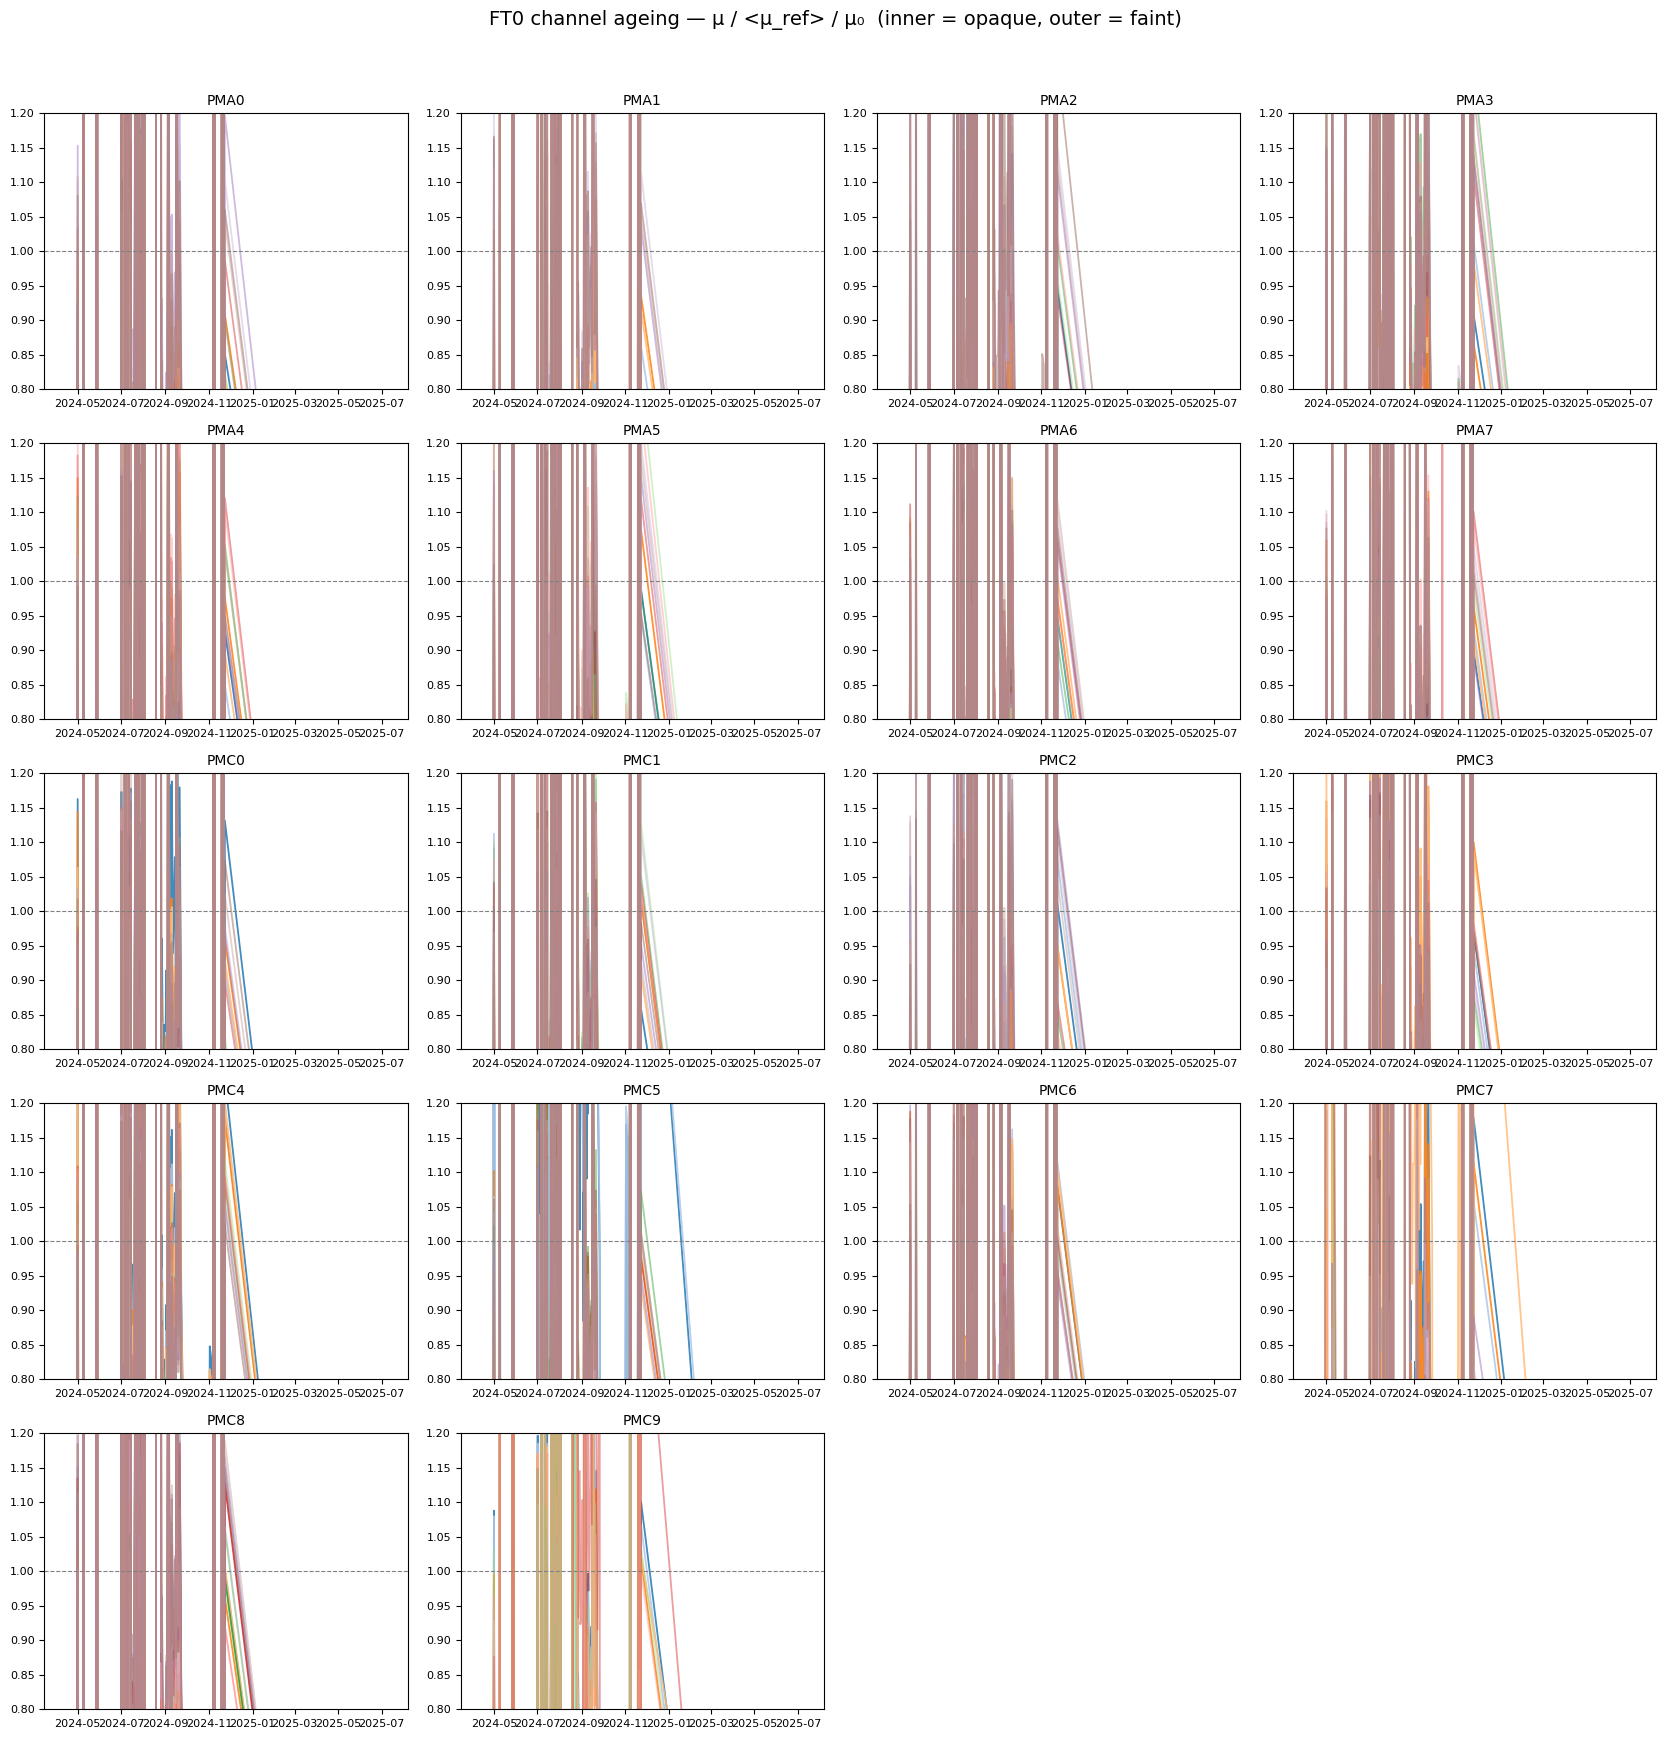

In [87]:
# ╔════════════════════════════════════════════════════════════════════════╗
# ║  CELL B – PM-by-PM ageing curves (clearer & auto-grid)                ║
# ╚════════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt, seaborn as sns, math

bad_refs = df["norm"].isna().sum()
print(f"⚠  dropped {bad_refs} rows without valid norm")

df_clean = df.dropna(subset=["norm"])

pms   = sorted(df_clean["pm"].dropna().unique())
cols  = 4
rows  = math.ceil(len(pms) / cols)
palette = sns.color_palette("tab20", 12)

plt.figure(figsize=(cols * 4.2, rows * 3.4))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

for i, pm in enumerate(pms, 1):
    ax = plt.subplot(rows, cols, i)
    sub = df_clean[df_clean["pm"] == pm]
    for j, (ch, g) in enumerate(sub.groupby("ch", sort=True)):
        ax.plot(g["time"], g["norm"],
                lw=1.3, color=palette[j % len(palette)],
                alpha=0.85 if g["ring"].iloc[0].endswith("inner") else 0.45)
    ax.set_title(pm, fontsize=10)
    ax.axhline(1, ls="--", lw=0.8, color="grey")
    ax.set_ylim(0.8, 1.2)
    ax.tick_params(labelsize=8)

plt.suptitle("FT0 channel ageing — μ / <μ_ref> / μ₀  (inner = opaque, outer = faint)",
             y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [105]:
# ▸ Cell A – fit μ per run (target ch 24 vs refs 208,210,211)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

TGT_CH   = 24
REF_CHS  = [208, 210, 211]
ADC_REF_RANGE = (150, 600)      # hard window for references
FRAC     = 0.25                 # ±25 % slice around the peak
BIN_W    = 8                    # ADC bin width used in Hch

def bin_centres_for(hist_len, bin_w=BIN_W):
    """Return an array of bin centres that matches *this* histogram length."""
    return np.arange(hist_len, dtype=np.float32) * bin_w + bin_w/2

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

def fit_mu(hist, is_ref=False, frac=FRAC):
    """Gaussian μ (np.nan on failure).  Refs pre-masked to 150–600 ADC."""
    if hist.sum() < 50:
        return np.nan

    x = bin_centres_for(len(hist))
    if is_ref:
        lo, hi = ADC_REF_RANGE
        m = (x >= lo) & (x <= hi)
        hist, x = hist[m], x[m]
        if hist.sum() < 30:
            return np.nan

    peak = x[np.argmax(hist)]
    for f in (frac, 0.35, 0.45, 0.60):
        m = (x >= (1-f)*peak) & (x <= (1+f)*peak)
        if hist[m].sum() < 10:
            continue
        try:
            p0 = (hist[m].max(), peak, 160.)
            popt, _ = curve_fit(
                gauss, x[m], hist[m], p0=p0, maxfev=5000,
                bounds=([0,   0,   0], [np.inf, 4096, 4096])
            )
            return popt[1]                   # μ
        except RuntimeError:
            pass
    return np.nan


records = []
for i in tqdm(range(len(runs)), desc="Gaussian fits"):
    mu_tgt  = fit_mu(Hch[i, TGT_CH], is_ref=False)
    mu_refs = [fit_mu(Hch[i, ch], is_ref=True) for ch in REF_CHS]
    mu_ref  = np.nanmean(mu_refs)

    if np.isfinite(mu_tgt) and np.isfinite(mu_ref):
        records.append({"run": runs[i], "idx": i,
                        "mu_tgt": mu_tgt, "mu_ref": mu_ref})

df = (pd.DataFrame(records)
        .sort_values("idx")
        .reset_index(drop=True))

# baseline-normalise to the very first accepted run
baseline = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref"]
df["aging"] = (df["mu_tgt"] / df["mu_ref"]) / baseline

print(f"Successfully fitted {len(df)}/{len(runs)} runs "
      f"({len(runs)-len(df)} skipped due to bad reference fits).")
df.head()

Gaussian fits:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_9079/2531017285.py:53: RuntimeWarning: Mean of empty slice
  mu_ref  = np.nanmean(mu_refs)


Successfully fitted 186/198 runs (12 skipped due to bad reference fits).


,run,idx,mu_tgt,mu_ref,aging
0,549661,5,163.437496,327.626260,1.000000
1,549749,6,173.612734,328.460044,1.059561
2,549824,7,182.997800,329.441654,1.113511
3,549853,8,183.105951,330.477076,1.110678
4,549958,9,171.819406,326.018650,1.056469


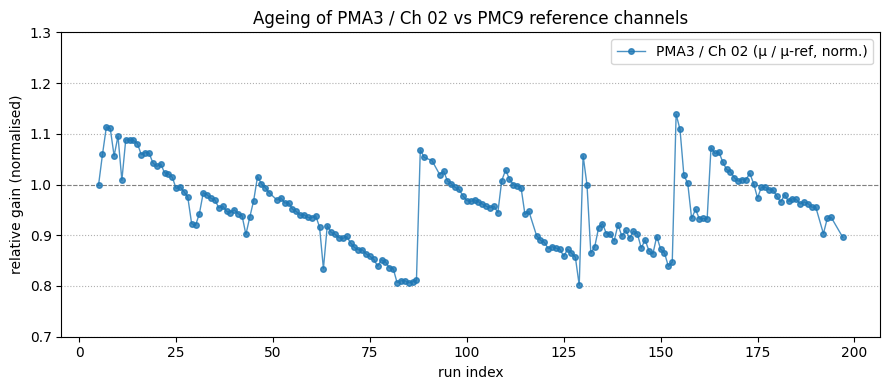

In [106]:
# ▸ Cell B – ageing curve visualisation
plt.figure(figsize=(9, 4))
plt.errorbar(df["idx"], df["aging"],
             fmt="o-", lw=1, ms=4, alpha=0.8, capsize=2,
             label="PMA3 / Ch 02 (μ / μ-ref, norm.)")
plt.axhline(1, color="grey", ls="--", lw=0.8)
plt.xlabel("run index")
plt.ylabel("relative gain (normalised)")
plt.title("Ageing of PMA3 / Ch 02 vs PMC9 reference channels")
plt.ylim(0.7, 1.3)
plt.grid(axis="y", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
run_meta = pd.read_json("../data/laserROOT/laser_runs.json")
df = df.merge(run_meta, how="left", on="run")
df["time"] = pd.to_datetime(df["start_ms"], unit="ms")

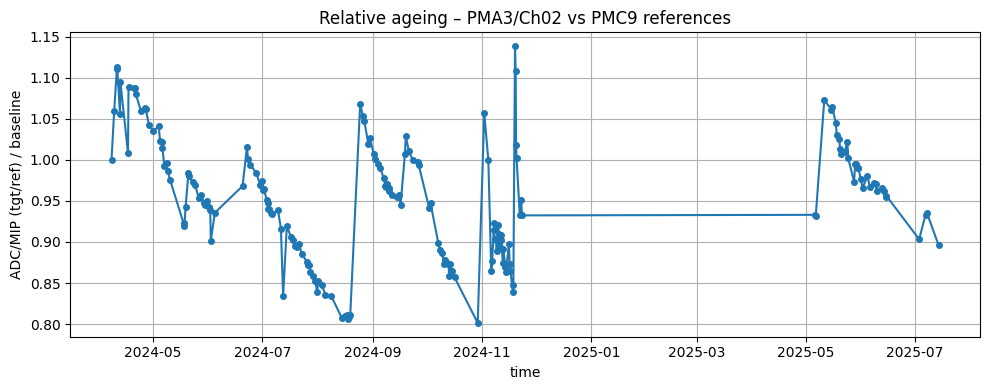

In [110]:
plt.figure(figsize=(10,4))
plt.plot(df["time"], df["aging"], "o-", ms=4)
plt.xlabel("time")
plt.ylabel("ADC/MIP (tgt/ref) / baseline")
plt.title("Relative ageing – PMA3/Ch02 vs PMC9 references")
plt.grid()
plt.tight_layout()
plt.show()

In [115]:
# ▸ Cell 1 – compute BOTH curves (old vs new)
import numpy as np, pandas as pd
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

TGT_CH   = 24
REF_CHS  = [208, 210, 211]
FRAC     = 0.25
BIN_W    = 8
ADC_REF_RANGE = (150, 600)     # new approach only

def centres(n):      # fast helper: correct length every time
    return np.arange(n, dtype=np.float32)*BIN_W + BIN_W/2

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def mu_fit(hist, ref=False, frac=FRAC):
    """Gaussian μ or nan.  If *ref*→ pre-mask to ADC_REF_RANGE."""
    if hist.sum() < 50:                 # too few entries
        return np.nan
    x = centres(len(hist))
    if ref:
        lo, hi = ADC_REF_RANGE
        m = (x >= lo) & (x <= hi)
        hist, x = hist[m], x[m]
        if hist.sum() < 30:
            return np.nan
    peak = x[np.argmax(hist)]
    for f in (frac, 0.35, 0.45, 0.60):
        m = (x >= (1-f)*peak) & (x <= (1+f)*peak)
        if hist[m].sum() < 10:
            continue
        try:
            p0 = (hist[m].max(), peak, 160.)
            return curve_fit(
                gauss, x[m], hist[m], p0=p0, maxfev=4000,
                bounds=([0, 0, 0], np.inf)
            )[0][1]
        except RuntimeError:
            pass
    return np.nan

records = []
for i in tqdm(range(len(runs)), desc="Gaussian fits"):
    h_tgt = Hch[i, TGT_CH]
    mu_tgt_old = mu_fit(h_tgt, ref=False)            # same for both
    mu_tgt_new = mu_tgt_old                          # identical target curve

    # ------- references --------
    mu_ref_old = np.nanmean([mu_fit(Hch[i, ch], ref=False) for ch in REF_CHS])
    mu_ref_new = np.nanmean([mu_fit(Hch[i, ch], ref=True ) for ch in REF_CHS])

    records.append(dict(run=runs[i], idx=i,
                        mu_tgt=mu_tgt_old,
                        mu_ref_old=mu_ref_old,
                        mu_ref_new=mu_ref_new))

df = (pd.DataFrame(records)
        .dropna(subset=["mu_ref_old","mu_ref_new"])   # drop runs with broken refs
        .sort_values("idx")
        .reset_index(drop=True))

# --- normalise both curves to their own first point ----------------------
base_old = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref_old"]
base_new = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref_new"]

df["aging_old"] = (df["mu_tgt"] / df["mu_ref_old"]) / base_old
df["aging_new"] = (df["mu_tgt"] / df["mu_ref_new"]) / base_new
print(df.head())

Gaussian fits:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_9079/592765318.py:51: RuntimeWarning: Mean of empty slice
  mu_ref_old = np.nanmean([mu_fit(Hch[i, ch], ref=False) for ch in REF_CHS])
/tmp/ipykernel_9079/592765318.py:52: RuntimeWarning: Mean of empty slice
  mu_ref_new = np.nanmean([mu_fit(Hch[i, ch], ref=True ) for ch in REF_CHS])
/tmp/ipykernel_9079/592765318.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(


      run  idx      mu_tgt  mu_ref_old  mu_ref_new  aging_old  aging_new
0  549661    5  163.436523         4.0  327.626260   1.000000   1.000000
1  549749    6  173.611473         4.0  328.460044   1.062256   1.059560
2  549824    7  182.994799         4.0  329.441654   1.119669   1.113499
3  549853    8  183.104426         4.0  330.477076   1.120340   1.110675
4  549958    9  171.819017         4.0  326.018650   1.051289   1.056473


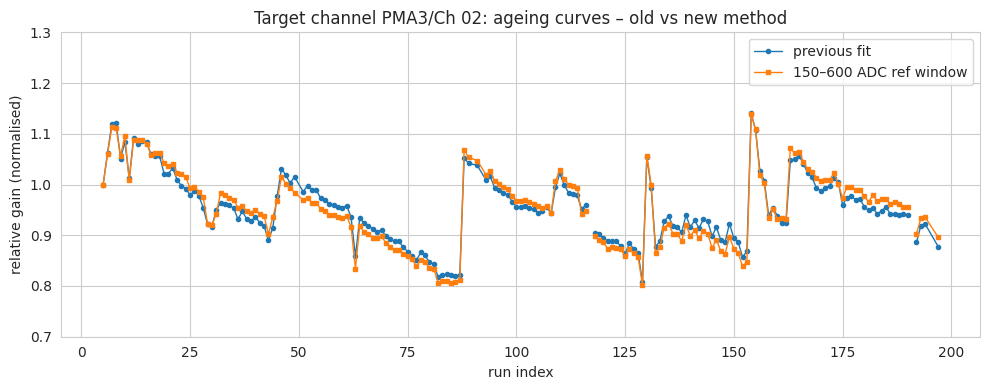

Δ (new−old) mean = -0.0004  RMS = 0.0152


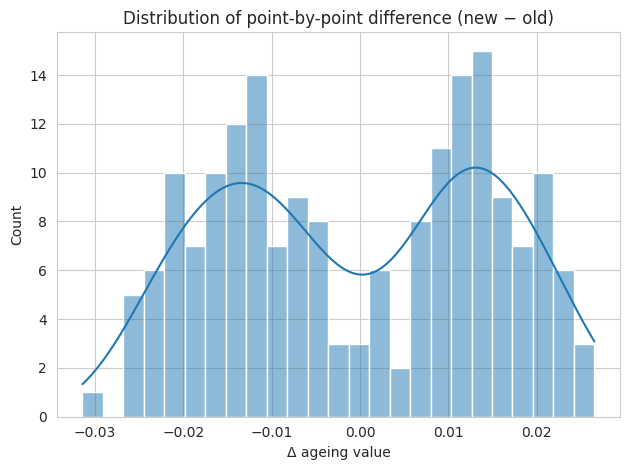

In [116]:
# ▸ Cell 2 – visual & numeric comparison
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10,4))
plt.plot(df["idx"], df["aging_old"], "o-", lw=1, ms=3, label="previous fit")
plt.plot(df["idx"], df["aging_new"], "s-", lw=1, ms=3, label="150–600 ADC ref window")
plt.xlabel("run index")
plt.ylabel("relative gain (normalised)")
plt.title("Target channel PMA3/Ch 02: ageing curves – old vs new method")
plt.ylim(0.7, 1.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- quantitative summary ------------------------------------------------
delta = df["aging_new"] - df["aging_old"]
print(f"Δ (new−old) mean = {delta.mean():+.4f}  "
      f"RMS = {delta.std():.4f}")
sns.histplot(delta, bins=25, kde=True)
plt.title("Distribution of point-by-point difference (new − old)")
plt.xlabel("Δ ageing value"); plt.tight_layout(); plt.show()